In [1]:
# загрузим необходимые библиотеки
import numpy as np
import pandas as pd

from PIL import Image
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras import regularizers

import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, \
    Flatten, BatchNormalization, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, \
    EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

from typing import *
from collections import Counter

import yaml

import warnings
warnings.filterwarnings('ignore')

# Import data

In [18]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)


training = config['train']
prediction = config['prediction']

In [4]:
# путь до папки
main_path = prediction['predict_path']

In [5]:
# загрузим путь до изображений в df
img_list = []
for img_file in os.listdir(main_path):
    img_list.append(main_path + '/' + img_file)

In [6]:
df = pd.DataFrame({'img': img_list})

In [7]:
df

,img
0,../data/check//Anthemis_arvensis_RF.jpg
1,../data/check//Leucanthemum_vulgare_'Filigran'...
2,../data/check//Matricaria_discoidea_-_lõhnav_k...
3,../data/check//Matricaria_February_2008-1.jpg
4,../data/check//Tanacetum_corymbosum_2.jpg
5,../data/check//Tripleurospermum_perforatum_av.jpg


In [19]:
# загрузим метки классов
label_map_path = training['label_map_path']

with open(label_map_path) as file:
    label_map = json.load(file)

In [16]:
# сохраним названия классов в список
lst_cls = list(label_map.keys())

# Preprocessing

In [12]:
# определим параметры
RAND = training['random_state']
image_size = (training['img_size'], training['img_size'])
img_shape = (image_size[0], image_size[1], training['channels'])
batch_size = training['batch_size']
n_class = training['n_class']

In [519]:
# функция для подготовки изображения перед подачей в модель
def prepare_image(img_path: str, image_size: Tuple[int, int]) -> np.ndarray:
    """
    Подготавливает изображение для подачи в модель.

    Parameters
    ----------
    img_path: str 
        Путь к изображению.
    image_size: Tuple[int, int]
        Размер изображения.

    Returns
    -------
    np.ndarray
        Подготовленное изображение в виде массива.
    """
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    
    return img_array

In [520]:
# приведем изображения к формату np.array для дальнешего подачи в мадель
preprocessed_images = []
for img_path in df['img']:
    preprocessed_image = prepare_image(img_path=img_path,
                                       image_size=image_size)
    preprocessed_images.append(preprocessed_image)

# Prediction

In [505]:
# определим функцию для создания модели
def create_model(base_model_name: MobileNetV2,
                 img_shape: Tuple[int, int, int],
                 n_class: int,
                 rand_seed: int,
                 optimizer: str = 'adam',
                 test_flg: bool = False) -> Sequential:
    """
    Создает модель нейронной сети на основе заданной базовой модели.
    
    Parameters
    ----------
    base_model_name: MobileNetV2
        Базовая модель.
    img_shape (Tuple[int, int, int]): 
        Размер входного изображения.
    n_class: int
        Количество классов.
    rand_seed: int
        random_state для воспроизводимости результата.
    optimizer: str
        Оптимизатор для модели.
    test_flg: bool
        Цель создания модели (True для тестирования, иначе для классификации).
    
    Returns
    -------
    Sequential
        Созданная модель нейронной сети.
    """
    # создадим базовую модель
    base_model = base_model_name(weights='imagenet',
                                 include_top=False,
                                 input_shape=img_shape)
    # заморозим слои (в зависимсоти от цели создания модели)
    if test_flg:
        for layer in base_model.layers:
            layer.trainable = False
    else:
        no_base_layers = len(base_model.layers)
        no_finetune_layers = int(no_base_layers / 4)
        base_model.trainable = True
        for layer in base_model.layers[:-no_finetune_layers]:
            layer.trainable = False

    # создадим модель CNN на основе базовой модели
    model = Sequential()
    model.add(Input(shape=img_shape))
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    if test_flg:
        # для тестирования базовых моделей
        model.add(
            Dense(32,
                  activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(rate=0.2, seed=rand_seed))
        model.add(Dense(n_class, activation='softmax'))
    else:
        # для классификации
        model.add(
            Dense(256,
                  activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(rate=0.2, seed=rand_seed))
        model.add(
            Dense(128,
                  activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(rate=0.1, seed=rand_seed))
        model.add(Dense(n_class, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.metrics.F1Score(average='macro')])

    return model

In [506]:
# определим функцию для callbacks
def callbacks_make(checkpoint_path: str,
                   checkpoint_flg: bool = False,
                   reduce_lr_flg: bool = False) -> List:
    """
    Создает список callbacks для обучения модели.
    
    Parameters
    ----------
    checkpoint_path: str
        Путь для сохранения checkpoint.
    checkpoint_flg: bool
        Флаг использования ModelCheckpoint.
    reduce_lr_flg: bool
        Флаг использования ReduceLROnPlateau.
    
    Returns
    -------
    List
        Список callbacks.
    """
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                   patience=3,
                                   verbose=0,
                                   restore_best_weights=False)
    callbacks = [early_stopping]

    if checkpoint_flg:
        checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                     save_weights_only=True,
                                     monitor='val_accuracy',
                                     verbose=1,
                                     save_best_only=True)
        callbacks.append(checkpoint)

    if reduce_lr_flg:
        reduce_lr = ReduceLROnPlateau(monitor="val_accuracy",
                                      factor=0.001,
                                      patience=10,
                                      verbose=1)
        callbacks.append(reduce_lr)

    return callbacks

In [521]:
# создадим модель
model = create_model(base_model_name=MobileNetV2,
                         img_shape=img_shape,
                         n_class=n_class,
                         rand_seed=RAND,
                         optimizer=tf.keras.optimizers.Adam(1e-5),
                         test_flg=False)

In [522]:
# загрузим предобученные веса
model.load_weights(training['model_path'])

In [523]:
# подадим подготовленные изображения в модель для получения предсказаний
predictions = []
for img_array in preprocessed_images:
    prediction = model.predict(img_array)
    predictions.append(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [510]:
def plot_image(image_path: str, prediction: np.ndarray, lst_cls: list) -> None:
    """
    Отображает изображение с предсказанием класса.

    Parameters
    ----------
    image_path: str 
        Путь к изображению.
    prediction: np.ndarray
        Предсказание модели.
    lst_cls: list
        Список классов.

    Returns
    -------
    None
     Вывод изображения с предсказанием класса.
    """

    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Prediction: {}".format(lst_cls[np.argmax(prediction[0])]))


def plot_value_array(prediction: np.ndarray) -> None:
    """
    Отображает график предсказаний модели для входного изображения.

    Parameters
    ----------
    prediction: np.ndarray
        Предсказание модели.

    Returns
    -------
    None
        Выводит график с предсказанием классов в %.
    """
    thisplot = plt.bar(label_map.keys(), prediction[0] * 100, color="gray")
    predicted_label = np.argmax(prediction[0])
    thisplot[predicted_label].set_color("green")
    plt.ylabel('Persantage')
    plt.xticks(rotation=45)
    plt.title('Model predictions classes')


def plot_final_result(data: pd.Series, predictions: np.ndarray,
                      lst_cls: list) -> None:
    """
    Отображает результаты предсказаний для нескольких изображений.

    Parameters
    ----------
    data: pd.Series 
        Набор изображений (путь к изображениям).
    predictions: np.ndarray
        Предсказания модели для каждого изображения.
    lst_cls: list
        Список классов.

    Returns
    -------
    None
        Выводит изображения и соответствующие им предсказания классов.
    """
    num_images = data.shape[0]
    nrows = num_images
    ncols = 2
    plt.figure(figsize=(10, 4 * nrows))

    for i in range(num_images):
        prediction = predictions[i]
        test_pred_classes = np.argmax(prediction[0])
        plt.subplot(nrows, ncols, 2 * i + 1)
        plot_image(image_path=data[i], prediction=prediction, lst_cls=lst_cls)
        plt.subplot(nrows, ncols, 2 * i + 2)
        plot_value_array(prediction=prediction)

    plt.tight_layout()
    plt.show()

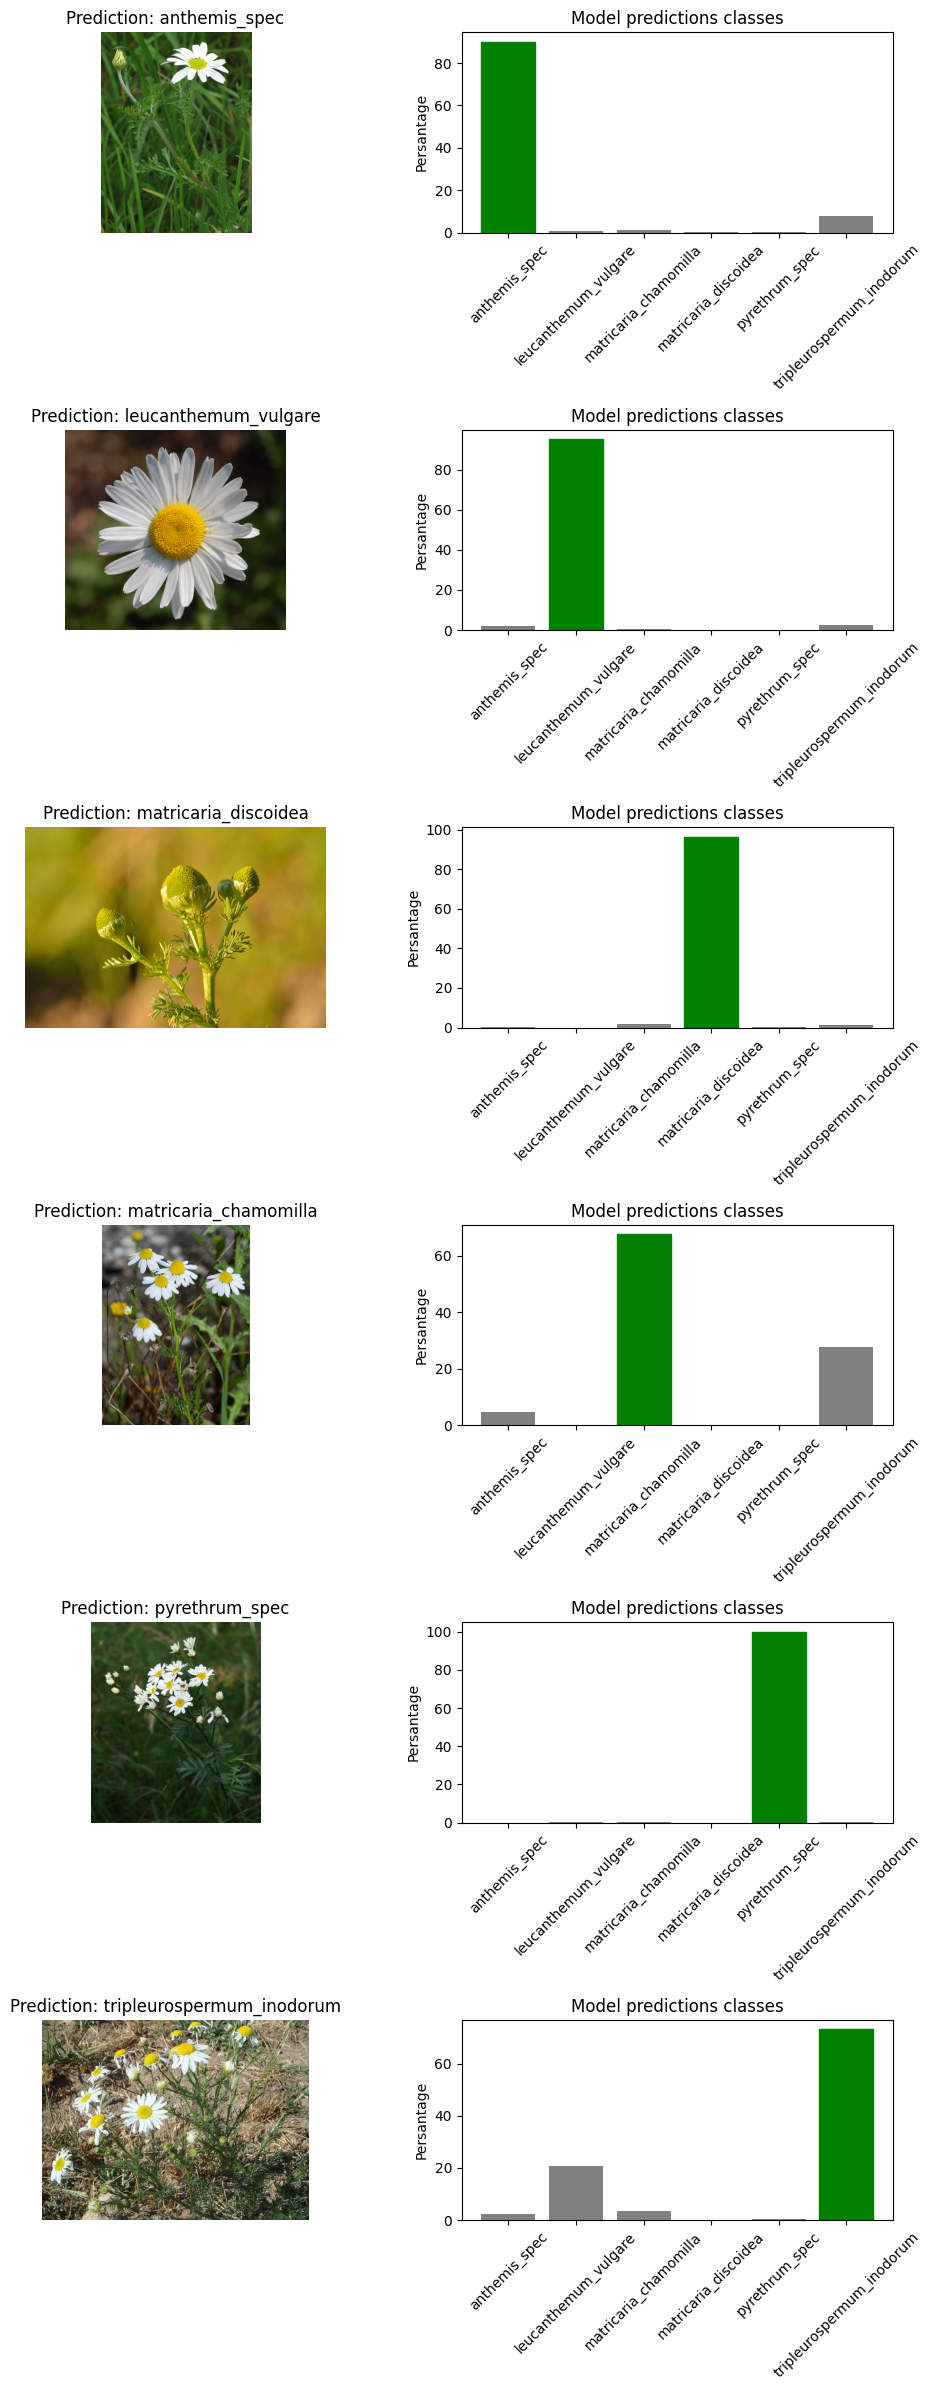

In [524]:
plot_final_result(data=df['img'], predictions=predictions, lst_cls=lst_cls)